In [1]:
# https://medium.com/spikelab/time-series-parameters-finding-using-prophet-and-optuna-bayesian-optimization-e618614bd8b7
# https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
import pandas as pd
from prophet import Prophet
import optuna
from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot
from prophet.make_holidays import make_holidays_df
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

In [2]:
df = pd.read_csv('don_20240502_NbArrivees_vf.csv', sep=';', parse_dates=['dhreinscription'])
df = df.rename(columns={"dhreinscription": "ds", "Total": "y"})
df = df[['ds', 'y']]
df.head()

ds   y
0 2016-01-01   8
1 2016-01-02   8
2 2016-01-03   8
3 2016-01-04  27
4 2016-01-05  30

In [3]:
df.tail()

ds   y
3039 2024-04-27   8
3040 2024-04-28  13
3041 2024-04-29  23
3042 2024-04-30  23
3043 2024-05-01  20

In [4]:
# Holidays from the calendar for Quebec
qc_holidays = make_holidays_df(
    year_list=[2016 + i for i in range(9)], country='CA', province='QC'
)

# Custom lockdown holidays
# https://en.wikipedia.org/wiki/Timeline_of_the_COVID-19_pandemic_in_Quebec
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-22'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-01', 'lower_window': 0, 'ds_upper': '2021-02-08'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

holidays = pd.concat([qc_holidays,lockdowns])

In [5]:
# Setup trial for optuna

def objective(trial):
    '''Train a prophet model and return the rmse'''
    params = {
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 5, 40),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 2, 7),
        #'n_changepoints' : trial.suggest_int('n_changepoints', 10, 40),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 100, log=True ),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 100, log=True ),
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.1, 100, log=True ),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.95),
        'holidays' : qc_holidays,
        'uncertainty_samples' : 0,
        'daily_seasonality': False
    }

    # modeling
    m = Prophet(**params)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=trial.suggest_int('monthly_seasonality', 2, 30))
    logging.getLogger("prophet").setLevel(logging.ERROR)
    logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
    m.fit(df) 
    number_initial_days = (df.ds.max() - df.ds.min()).days - 28
    df_cv = cross_validation(m,
                             initial=f'{number_initial_days} days',
                             horizon = '7 days',
                             parallel="processes")
    df_p = performance_metrics(df_cv, metrics=['rmse'], rolling_window=1)
    return df_p['rmse'].values[0]

In [6]:
def train_final_model(df, study):
    best_params = study.best_params
    params = best_params.copy()
    params.pop('monthly_seasonality')
    # modeling
    m = Prophet(interval_width= 0.95,
                mcmc_samples=50,
                holidays=qc_holidays,
                daily_seasonality= False,
                **params)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['monthly_seasonality'])
    logging.getLogger("prophet").setLevel(logging.ERROR)
    logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
    m.fit(df)
    return m

In [21]:
study = optuna.create_study()
study.enqueue_trial(
  {'yearly_seasonality': 33,
 'weekly_seasonality': 2,
 'seasonality_prior_scale': 0.4349970988007901,
 'holidays_prior_scale': 0.10723030806399333,
 'changepoint_prior_scale': 0.96876982672108,
 'seasonality_mode': 'multiplicative',
 'changepoint_range': 0.8849391644916493,
 'monthly_seasonality': 16})
study.optimize(objective, n_trials=1000, n_jobs=1, show_progress_bar=True)

[I 2024-05-31 10:18:19,762] A new study created in memory with name: no-name-1187de0a-8f48-424e-b653-f2b5cab6a598


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-31 10:18:37,672] Trial 0 finished with value: 3.865601536292729 and parameters: {'yearly_seasonality': 33, 'weekly_seasonality': 2, 'seasonality_prior_scale': 0.4349970988007901, 'holidays_prior_scale': 0.10723030806399333, 'changepoint_prior_scale': 0.96876982672108, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8849391644916493, 'monthly_seasonality': 16}. Best is trial 0 with value: 3.865601536292729.
[I 2024-05-31 10:18:55,867] Trial 1 finished with value: 4.317065587301791 and parameters: {'yearly_seasonality': 8, 'weekly_seasonality': 6, 'seasonality_prior_scale': 0.15480068963277394, 'holidays_prior_scale': 0.23874030717003028, 'changepoint_prior_scale': 1.9398970133532114, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8546378569194109, 'monthly_seasonality': 25}. Best is trial 0 with value: 3.865601536292729.
[I 2024-05-31 10:19:15,121] Trial 2 finished with value: 4.794198515399637 and parameters: {'yearly_seasonality': 21, 'weekly_seas

Process ForkProcess-8039:
Process ForkProcess-8040:
Process ForkProcess-8038:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkProcess-8036:
Traceback (most recent call last):
  File "/scratch/devgab/C3_admissions/timeseries/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/scratch/devgab/C3_admissions/timeseries/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/devgab/C3_admissions/timeseries/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/scratch/devgab/C3_admissions/timeseries/lib/python3.12/concurrent/futures/process.py", line 251, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/scratch/devgab/C3_admissions/timeseries/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self

[W 2024-05-31 10:19:42,811] Trial 4 failed with parameters: {'yearly_seasonality': 25, 'weekly_seasonality': 7, 'seasonality_prior_scale': 2.4350934264246633, 'holidays_prior_scale': 1.5461459710301444, 'changepoint_prior_scale': 0.21825173606786977, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9289119823549143, 'monthly_seasonality': 13} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/scratch/devgab/C3_admissions/timeseries/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/user/1111/ipykernel_3721051/2739221411.py", line 26, in objective
    df_cv = cross_validation(m,
           ^^^^^^^^^^^^^^^^^^^
  File "/scratch/devgab/C3_admissions/timeseries/lib/python3.12/site-packages/prophet/diagnostics.py", line 212, in cross_validation
    return pd.concat(predicts, axis=0).reset_index(drop=True)
           ^^^^^^^^^

KeyboardInterrupt: 

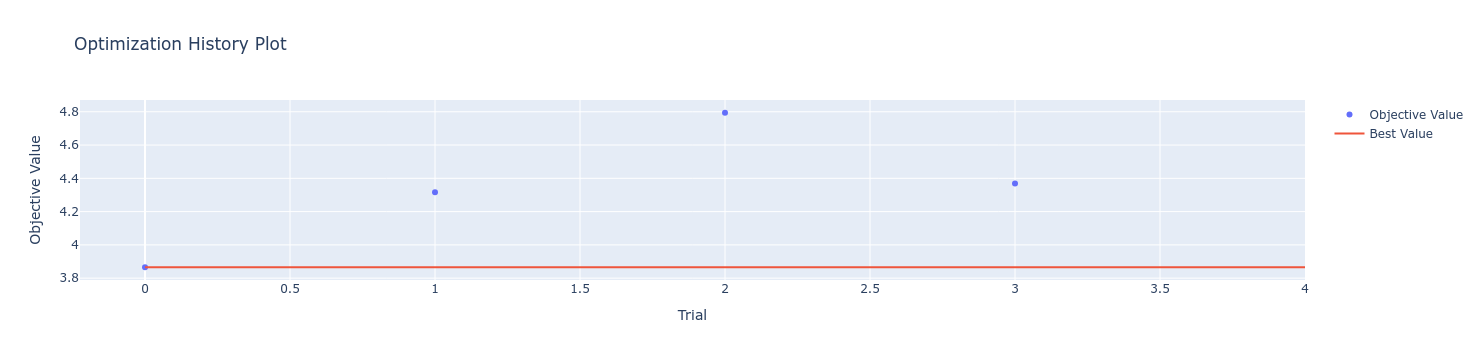

In [22]:
plot_optimization_history(study)

In [ ]:
#plot_contour(study)

In [23]:
m = train_final_model(df, study)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [24]:
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
3046 2024-05-04  13.649399    4.082955   22.413209
3047 2024-05-05  13.645368    5.135667   22.912789
3048 2024-05-06  20.707134   11.626216   29.675128
3049 2024-05-07  22.488953   14.225439   31.801396
3050 2024-05-08  20.722236   11.774405   28.733602

/scratch/devgab/C3_admissions/timeseries/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/scratch/devgab/C3_admissions/timeseries/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



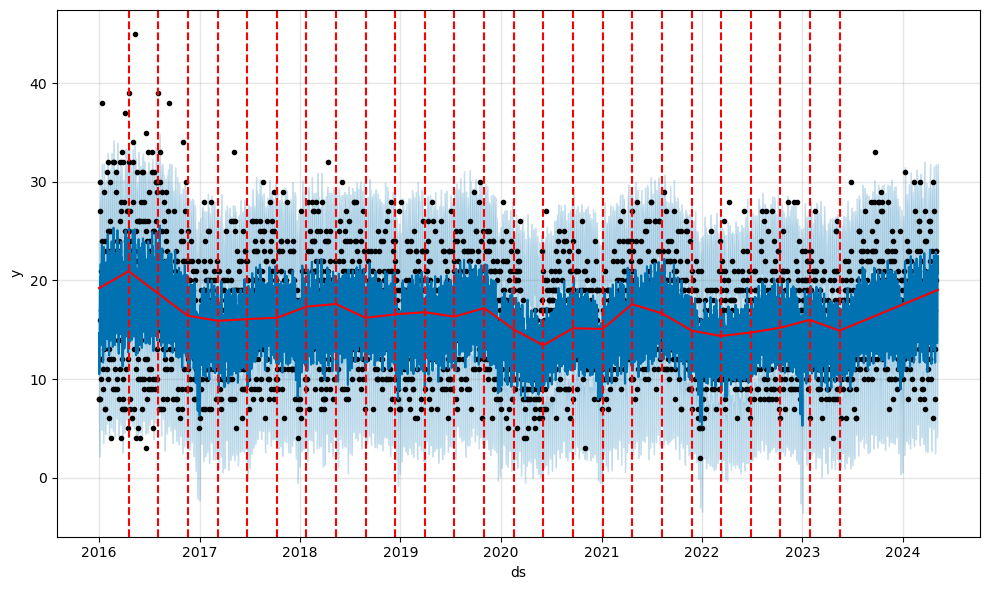

In [25]:
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

/scratch/devgab/C3_admissions/timeseries/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/scratch/devgab/C3_admissions/timeseries/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/scratch/devgab/C3_admissions/timeseries/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

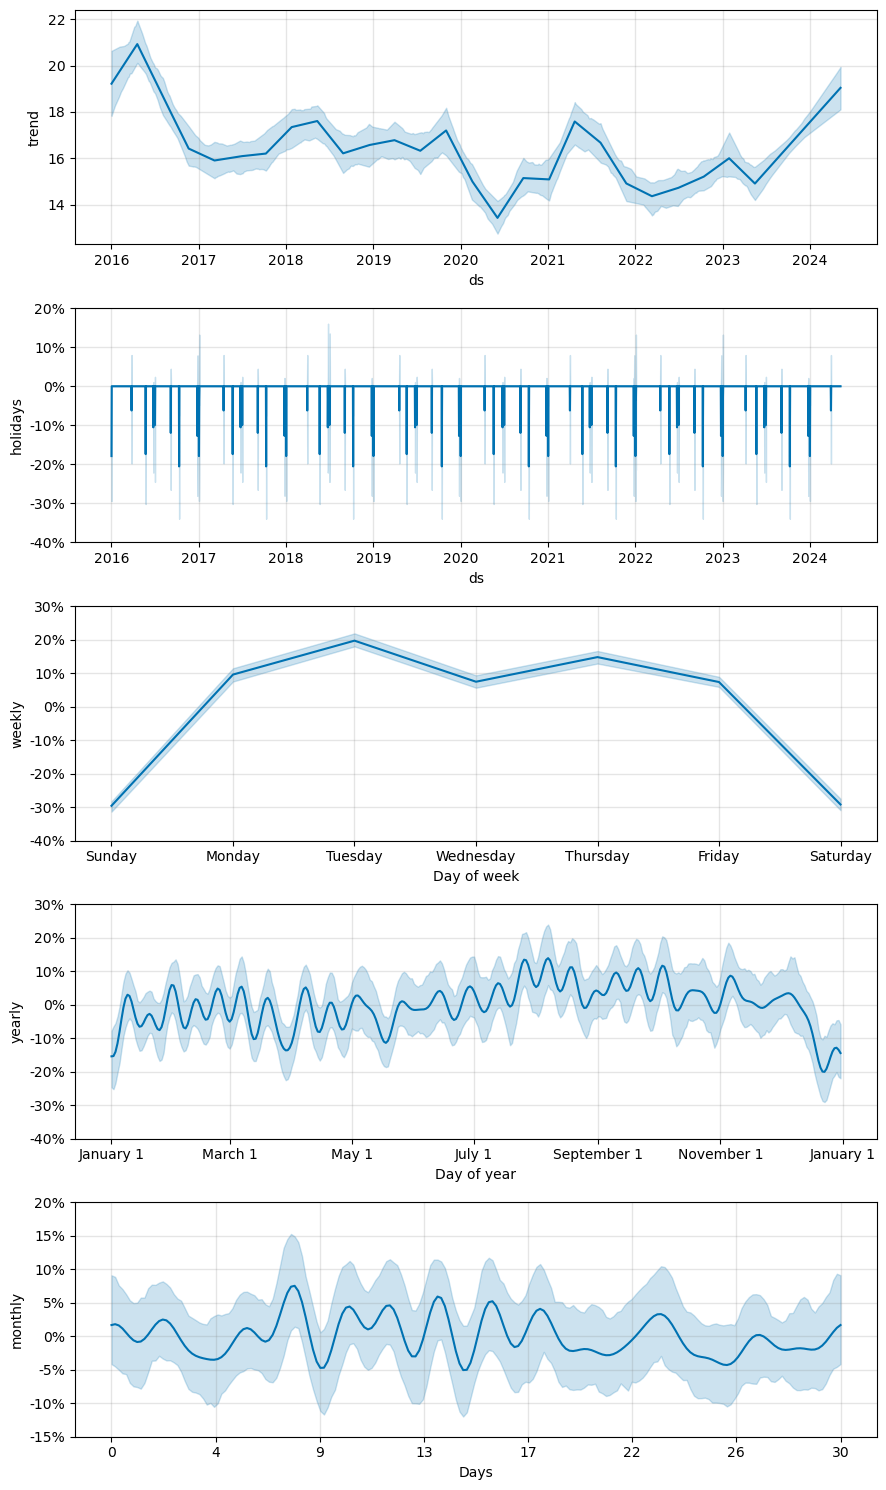

In [26]:
fig2 = m.plot_components(forecast)


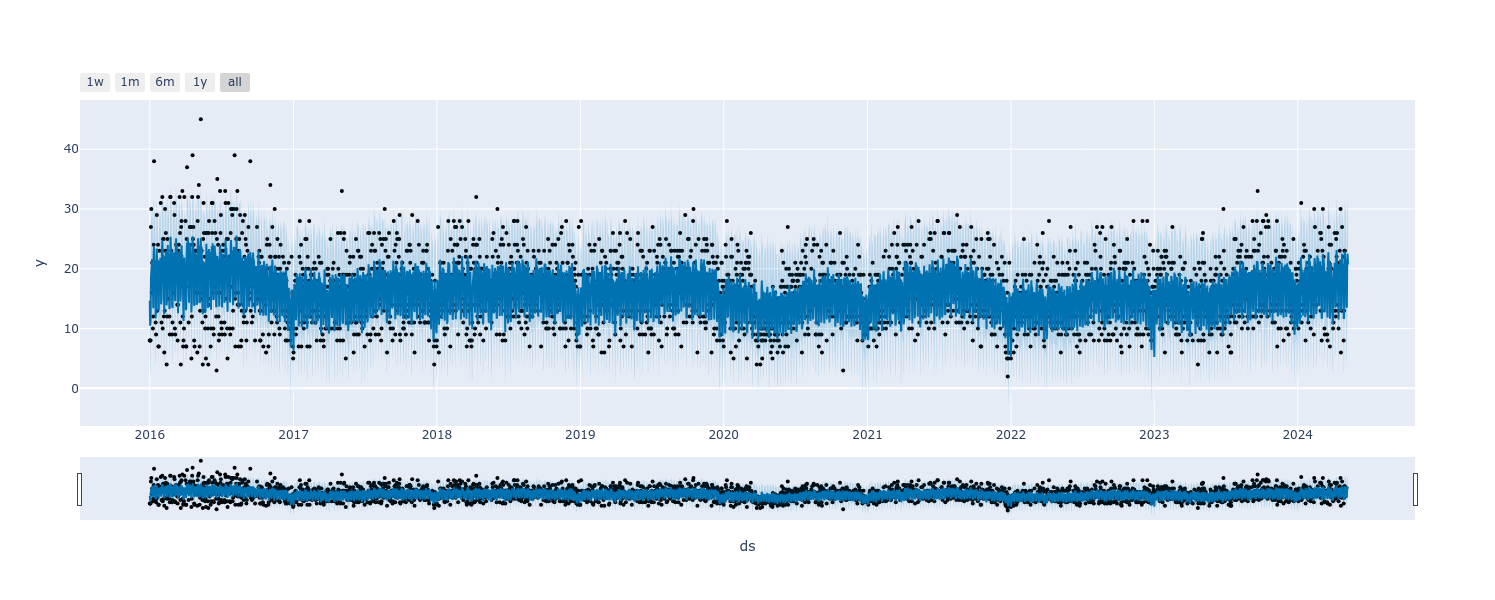

In [27]:
plot_plotly(m, forecast)

/scratch/devgab/C3_admissions/timeseries/lib/python3.12/site-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



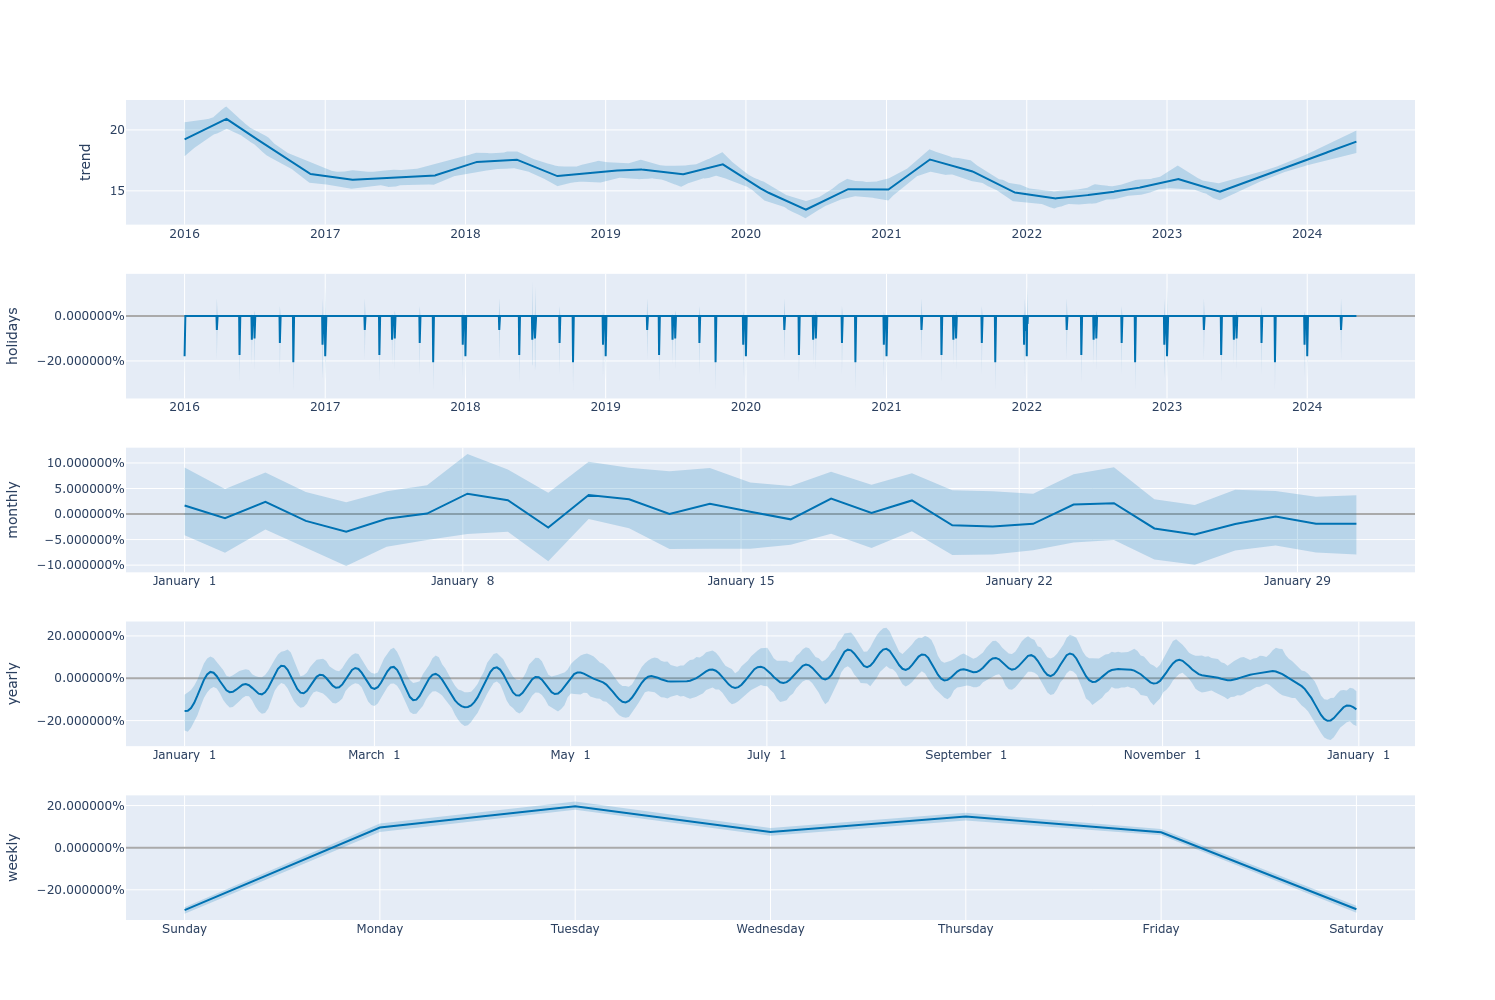

In [28]:
plot_components_plotly(m, forecast)


In [29]:
study.best_params

{'yearly_seasonality': 33,
 'weekly_seasonality': 2,
 'seasonality_prior_scale': 0.4349970988007901,
 'holidays_prior_scale': 0.10723030806399333,
 'changepoint_prior_scale': 0.96876982672108,
 'seasonality_mode': 'multiplicative',
 'changepoint_range': 0.8849391644916493,
 'monthly_seasonality': 16}

In [30]:
study.best_value

3.865601536292729

In [ ]:
import json

with open('best.json', 'w') as fp:
    json.dump(study.best_params, fp)